In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from transformers import ViTImageProcessor, TFViTModel
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [2]:
# Check available GPUs
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available: 1


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Tue Nov  5 11:52:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Load images from folder
def load_images_from_folder(folder, limit=None):
    images = []
    all_filenames = os.listdir(folder)[:limit]
    for filename in tqdm(all_filenames):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images

# Function to apply a malicious attack (adding noise to an image)
def apply_malicious_attack(img):
    noisy_img = img.copy()
    num_pixels = int(0.1 * img.size)
    x_coords = np.random.randint(0, img.shape[0], num_pixels)
    y_coords = np.random.randint(0, img.shape[1], num_pixels)
    noisy_img[x_coords, y_coords] = np.random.randint(0, 256, (num_pixels, 3))
    return np.clip(noisy_img, 0, 255)


In [4]:
# Initialize the ViT model and image processor
feature_extractor = ViTImageProcessor.from_pretrained("/kaggle/input/hugging-face-google-vit/google-vit-base-patch16-224-in21k")
vit_model = TFViTModel.from_pretrained("/kaggle/input/hugging-face-google-vit/google-vit-base-patch16-224-in21k", from_pt=True)
vit_model.trainable = True  # Fine-tune last few layers

# Change 4: Unfreeze last few layers of ViT model for fine-tuning
for layer in vit_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True
    
# Define paths to your datasets
train_dataset_path = '/kaggle/input/watermarked-not-watermarked-images/wm-nowm/train/watermark'
valid_dataset_path = '/kaggle/input/watermarked-not-watermarked-images/wm-nowm/valid/watermark'

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [5]:
# Load and preprocess images
watermarked_train_images = load_images_from_folder(train_dataset_path, limit=1500)
watermarked_valid_images = load_images_from_folder(valid_dataset_path, limit=1000)

# Resize and normalize images
X_train_resized = np.array([cv2.resize(img, (224,224)) for img in watermarked_train_images]).astype(np.float32) / 255.0
X_valid_resized = np.array([cv2.resize(img, (224,224)) for img in watermarked_valid_images]).astype(np.float32) / 255.0

100%|██████████| 1000/1000 [00:06<00:00, 150.24it/s]


In [6]:
# Generate embeddings in batches
def generate_embeddings_in_batches(images, batch_size=16):
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        batch_embeddings = vit_model(feature_extractor(batch_images, return_tensors='tf')['pixel_values']).last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings.numpy())
    return np.concatenate(embeddings, axis=0)

# Generate embeddings for the original images
with tf.device('/GPU:0'):
    train_embeddings = generate_embeddings_in_batches(X_train_resized)
    valid_embeddings = generate_embeddings_in_batches(X_valid_resized)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [7]:
# Create tampered images and generate their embeddings
slightly_tampered_images = np.array([np.clip(img + np.random.normal(0, 0.01, img.shape), 0, 1) for img in X_train_resized])
maliciously_tampered_images = np.array([np.clip(apply_malicious_attack(img), 0, 255) / 255.0 for img in X_train_resized])

# Generate embeddings for the tampered images
with tf.device('/GPU:0'):
    slightly_tampered_embeddings = generate_embeddings_in_batches(slightly_tampered_images)
    maliciously_tampered_embeddings = generate_embeddings_in_batches(maliciously_tampered_images)

In [8]:
# Combine embeddings and labels
y_train_labels = np.array([0] * len(train_embeddings) +
                          [1] * len(slightly_tampered_embeddings) +
                          [2] * len(maliciously_tampered_embeddings))

y_train_data = np.concatenate([train_embeddings, slightly_tampered_embeddings, maliciously_tampered_embeddings], axis=0)

# Shuffle the data
y_train_labels, train_embeddings = shuffle(y_train_labels, y_train_data)

# Flatten embeddings for DNN
train_embeddings_flattened = train_embeddings.reshape(-1, 768)

# Create validation labels
y_valid_labels = np.array([0] * len(valid_embeddings) +
                          [1] * len(slightly_tampered_embeddings) +
                          [2] * len(maliciously_tampered_embeddings))

y_valid_data = np.concatenate([valid_embeddings, slightly_tampered_embeddings, maliciously_tampered_embeddings], axis=0)

# Shuffle the validation data
y_valid_labels, valid_embeddings = shuffle(y_valid_labels, y_valid_data)

# Flatten embeddings for DNN
valid_embeddings_flattened = valid_embeddings.reshape(-1, 768)

In [9]:
# Change 1 & 6: Define DNN model with Dropout, Batch Normalization, and L2 Regularization
dnn_model = models.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),  # Adjusted dropout for overfitting reduction
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

# Change 2 & 3: Use a smaller initial learning rate and add learning rate scheduler
initial_learning_rate = 5e-5  # Adjusted learning rate
dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr

In [10]:
lr_scheduler = LearningRateScheduler(lr_schedule)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_dnn_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the DNN model
dnn_history = dnn_model.fit(train_embeddings_flattened, y_train_labels,
                             epochs=50,
                             batch_size=32,
                             validation_data=(valid_embeddings_flattened, y_valid_labels),
                             callbacks=[early_stopping, reduce_lr, model_checkpoint, lr_scheduler])

# Load the best model
dnn_model.load_weights('best_dnn_model.keras')

Epoch 1/50


I0000 00:00:1730807885.140101      93 service.cc:145] XLA service 0x7e7bd4016920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730807885.140157      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 83/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4369 - loss: 7.6205

I0000 00:00:1730807889.076514      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4798 - loss: 7.4592 - val_accuracy: 0.2500 - val_loss: 7.1329 - learning_rate: 5.0000e-05
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6226 - loss: 6.4807 - val_accuracy: 0.2500 - val_loss: 6.6808 - learning_rate: 5.0000e-05
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6416 - loss: 5.9061 - val_accuracy: 0.2500 - val_loss: 6.1670 - learning_rate: 5.0000e-05
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6392 - loss: 5.5052 - val_accuracy: 0.4685 - val_loss: 5.4603 - learning_rate: 5.0000e-05
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6416 - loss: 5.1333 - val_accuracy: 0.6665 - val_loss: 4.9707 - learning_rate: 5.0000e-05
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6391 - loss: 4.8377 - val_accuracy: 0.7160 - val_loss: 4.6918 - learning_rate: 5.0000e-05
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6639 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                      precision    recall  f1-score   support

            Original       0.40      0.88      0.55      1000
   Slightly Tampered       0.58      0.11      0.18      1500
Maliciously Tampered       0.99      1.00      0.99      1500

            accuracy                           0.63      4000
           macro avg       0.66      0.66      0.57      4000
        weighted avg       0.69      0.63      0.58      4000



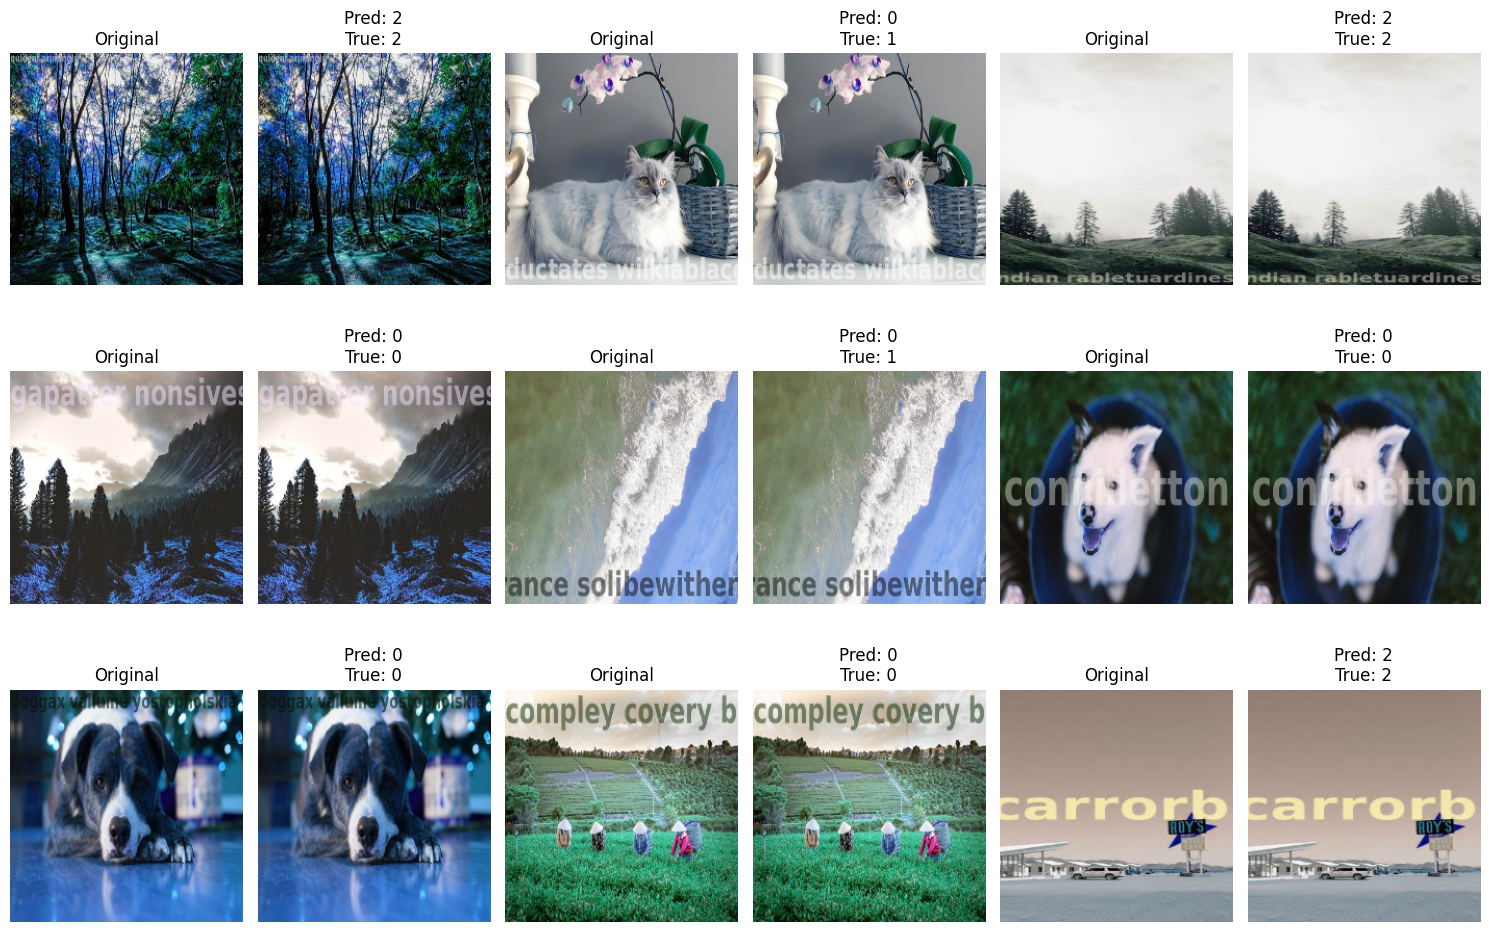

In [11]:
# Visualize predictions with validation images
def visualize_predictions(original_images, predicted_labels, true_labels):
    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 6, 2 * i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, 6, 2 * i + 2)
        plt.imshow(original_images[i])
        plt.title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get predictions on validation data
dnn_predictions = dnn_model.predict(valid_embeddings_flattened)
dnn_predicted_labels = np.argmax(dnn_predictions, axis=1)

# Print classification report
print(classification_report(y_valid_labels, dnn_predicted_labels, target_names=['Original', 'Slightly Tampered', 'Maliciously Tampered']))

# Visualize predictions
visualize_predictions(X_valid_resized[:9], dnn_predicted_labels[:9], y_valid_labels[:9])


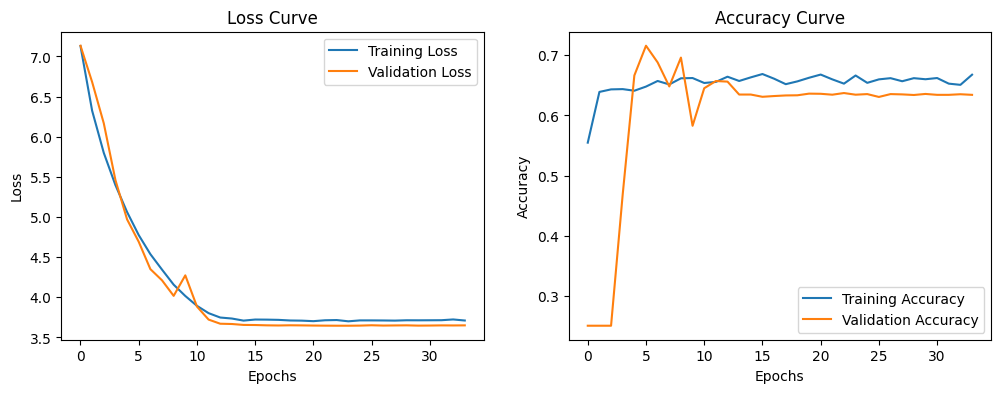

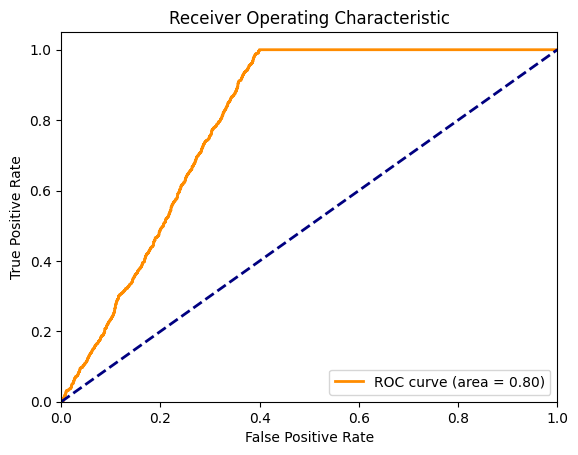

In [12]:
# Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training curves
plot_training_curves(dnn_history)

# Plot ROC Curve
def plot_roc_curve(y_true, y_scores):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores[:, 1], pos_label=1)  # Adjust for the class of interest
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for slightly tampered images
plot_roc_curve(y_valid_labels, dnn_predictions)
